In [1]:
import pybaseball as pyb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

# 공의 스핀과 무브먼트

공의 무브먼트는 스핀의 영향을 받는다. 공은 3가지 축을 중심으로 스핀하는데, x축에 대한 스핀은 상하무브먼트를, z축에 대한 스핀은 좌우무브먼트에 영향을 미친다. 이 두가지 회전에 의해 공 주변 기압차가 생기고, 이 기압차로 생기는 마그누스 힘은 공의 움직임을 발생시킨다. 반면에 공의 진행방향인 y축에 대한 스핀은 자이로 스핀으로, 공의 무브먼트에 영향을 주지 않는 스핀이다. Statcast 데이터를 이용하여 스핀과 무브먼트 관계에 대한 이론을 확인해보았다.  
   
    
트레버 바우어 선수의 투구 데이터를 추출하여, 바우어의 대표적인 4가지 구종에 대한 스핀과 무브먼트를 시각화하여 비교하였다.

#### **- [Movement by Pitch](#movement)**

#### **- [포심](#4-seam)**

#### **- [커브](#curve)**
       
#### **- [슬라이더](#slider)**

#### **- [커터](#cutter)**

----

## MLB Statcast Data

In [2]:
df = pyb.statcast('2021-04-01', '2021-10-03')

This is a large query, it may take a moment to complete


100%|██████████| 186/186 [02:34<00:00,  1.20it/s]


## Spin Direction, Axis, Efficiency 계산

statcast 데이터를 이용해서 각 투구의 스핀 효율을 계산하였다. 계산에 사용된 변수들을(바람, 온도, 습도) 모두 상수로 가정하여 계산하였기 때문에 실제 스핀 효율과 차이가 있을 수 있다.

참조: http://baseball.physics.illinois.edu/trackman/SpinAxis.pdf

In [85]:
mass=5.125
circ=9.125
rho_1=0.075
K = 0.07182*rho_1*(5.125/mass)*((circ/9.125)**2)

df['yR'] = 60.5-df['release_extension']
df['tR'] = (df['vy0']*(-1) - np.sqrt(df['vy0']**2-2*df['ay']*(50-df['yR'])))/df['ay']
df['vxR'] = df['vx0']+df['ax']*df['tR']
df['vyR'] = df['vy0']+df['ay']*df['tR']
df['vzR'] = df['vz0']+df['az']*df['tR']
df['dv0'] = df['release_speed']-np.sqrt(df['vxR']**2+df['vyR']**2+df['vzR']**2)/1.467

df['tf'] = ((-1)*df['vyR']-np.sqrt(df['vyR']**2-2*df['ay']*(df['yR']-17/12)))/df['ay']
df['calculated_x_mvt'] = df['plate_x']-df['release_pos_x']-(df['vxR']/df['vyR'])*(17/12-df['yR'])
df['calculated_z_mvt'] = df['plate_z']-df['release_pos_z']-(df['vzR']/df['vyR'])*(17/12-df['yR'])+0.5*32.174*(df['tf']**2)

df['vxbar']= (2*df['vxR'] + df['ax']*df['tf'])/2
df['vybar']= (2*df['vyR'] + df['ay']*df['tf'])/2
df['vzbar']= (2*df['vzR'] + df['az']*df['tf'])/2
df['vbar'] = np.sqrt(df['vxbar']**2+df['vybar']**2+df['vzbar']**2)

df['adrag'] = (-1)*(df['ax']*df['vxbar']+df['ay']*df['vybar']+(df['az']+32.174)*df['vzbar'])/df['vbar']
df['amagx'] = df['ax'] + df['adrag']*df['vxbar']/df['vbar']
df['amagy'] = df['ay'] + df['adrag']*df['vybar']/df['vbar']
df['amagz'] = df['az'] + df['adrag']*df['vzbar']/df['vbar']+32.174
df['amag'] = np.sqrt(df['amagx']**2+df['amagy']**2+df['amagz']**2)

df['Mx'] = 0.5*df['amagx']*(df['tf']**2)*12
df['Mz'] = 0.5*df['amagz']*(df['tf']**2)*12

df['Cd']=df['adrag']/(K*(df['vbar']**2))
df['Cl']=df['amag']/(K*(df['vbar']**2))
df['S']=0.166*np.log(0.336/(0.336-df['Cl']))

df['spinT']=78.92*df['S']*df['vbar']
df['spinTX']=df['spinT']*(df['vybar']*df['amagz']-df['vzbar']*df['amagy'])/(df['amag']*df['vbar'])
df['spinTY']=df['spinT']*(df['vzbar']*df['amagx']-df['vxbar']*df['amagz'])/(df['amag']*df['vbar'])
df['spinTZ']=df['spinT']*(df['vxbar']*df['amagy']-df['vybar']*df['amagx'])/(df['amag']*df['vbar'])
df['gyro'] = np.sqrt(df['release_spin_rate']**2 - df['spinT']**2)

df['spin-check'] = np.sqrt(df['spinTX']**2+df['spinTY']**2+df['spinTZ']**2)-df['spinT']
df['phi'] = np.where(df['amagz']>0, np.arctan2(df['amagx'], df['amagz'])*(180/np.pi)+90, 360+np.arctan2(df['amagx'], df['amagz'])*(180/np.pi)+90)
df['spin_eff'] = df['spinT']/df['release_spin_rate']
df['theta'] = np.where(df['spin_eff']<=1, np.arccos(df['spin_eff'])*180/np.pi, '')

mlb_21 = df[df['spin_eff']<1]
mlb_21['theta'] = mlb_21['theta'].astype('float')
mlb_21['phi']= np.where(mlb_21['phi']>360, mlb_21['phi']-360, mlb_21['phi'])
mlb_21['theta']= np.where(mlb_21['theta']>360, mlb_21['theta']-360, mlb_21['theta'])
mlb_21['pfx_x_p'] = (-1)*mlb_21['pfx_x']
mlb_21['theta'] = np.where(mlb_21['phi']>180, 180-mlb_21['theta'], mlb_21['theta'])
mlb_21['theta'] = np.where(mlb_21['phi']<90, 360-mlb_21['theta'], mlb_21['theta'])

## 시각화 함수

In [86]:
def ball_spin(player, pitch_name):
    pitch_type = player[player['pitch_name']==pitch_name]
    player_avg = player.groupby(['pitch_name']).agg({'phi': 'mean', 'theta': 'mean', 'release_spin_rate': 'mean'}).reset_index()
    player_avg['phi'] = player_avg['phi']
    player_avg['theta'] = player_avg['theta']
    pitch_avg = player_avg[player_avg['pitch_name']==pitch_name]
    pitch_avg['release_spin_rate'].item()

    fig, (ax1, ax2) = plt.subplots(ncols=2, subplot_kw={'projection': 'polar'}, figsize=(15,15))
    plt.subplots_adjust(wspace=0.5)
    ax1.set_xticks(np.linspace(0, 2*np.pi, 12, endpoint=False))
    ax1.get_yaxis().set_visible(False)
    ax1.scatter(pitch_type['phi'].apply(np.deg2rad), pitch_type['release_spin_rate'])

    ax1.annotate("", xy=(np.deg2rad(pitch_avg['phi'].item()),500), xytext=(np.deg2rad(pitch_avg['phi'].item()),pitch_avg['release_spin_rate'].item()),
             arrowprops=dict(headwidth=10, headlength=10, width=1, color='red'))
    ax1.annotate("",  xy=(np.deg2rad(pitch_avg['phi'].item()+180),pitch_avg['release_spin_rate'].item()), xytext=(0,0),
             arrowprops=dict(headwidth=10, headlength=10, width=1, color='red'), size=20, color='red')


    ax1.set_title('Pitcher View', size=15)

    ax2.set_xticks(np.linspace(0, 2*np.pi, 12, endpoint=False))
    ax2.get_yaxis().set_visible(False)
    ax2.scatter(pitch_type['theta'].apply(np.deg2rad), pitch_type['release_spin_rate'])

    ax2.annotate("", xy=(np.deg2rad(pitch_avg['theta'].item()),500), xytext=(np.deg2rad(pitch_avg['theta'].item()),pitch_avg['release_spin_rate'].item()),
             arrowprops=dict(headwidth=10, headlength=10, width=1, color='red'))
    ax2.annotate("",  xy=(np.deg2rad(pitch_avg['theta'].item()+180),pitch_avg['release_spin_rate'].item()), xytext=(0,0),
             arrowprops=dict(headwidth=10, headlength=10, width=1, color='red'), size=20, color='red')

    ax2.annotate("Ball Moving", xy=(0, pitch_avg['release_spin_rate'].item()), xytext=(np.pi, pitch_avg['release_spin_rate'].item()), 
             arrowprops=dict(headwidth=10, headlength=10, width=1, color='green', lw=5), size=15, color='green')

    ax2.set_title('Top View', size=15)

    plt.show()

----

# 1. Trevor Bauer

시각화를 통해 공의 스핀과 무브먼트의 관계를 해석하기 위해, 트레버 바우어 선수의 투구 데이터를 활용하였다. 트레버 바우어는 오른손 투수이다.

## 1-1. 선수 데이터

In [87]:
bauer = mlb_21[mlb_21['player_name']=='Bauer, Trevor']

<a id="movement"></a>
## 1-2. Movement by Pitch

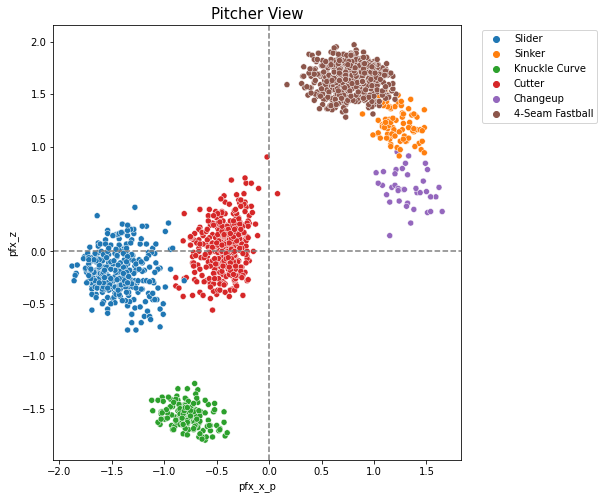

In [88]:
plt.figure(figsize=(8,8))
sns.scatterplot(data=bauer, x='pfx_x_p', y='pfx_z', hue='pitch_name')
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Pitcher View', size=15)
plt.show()

## 1-3. 구종별 시각화

In [56]:
pitch_list = ['4-Seam Fastball', 'Cutter', 'Slider', 'Knuckle Curve']

<a id="4-seam"></a>
### 포심

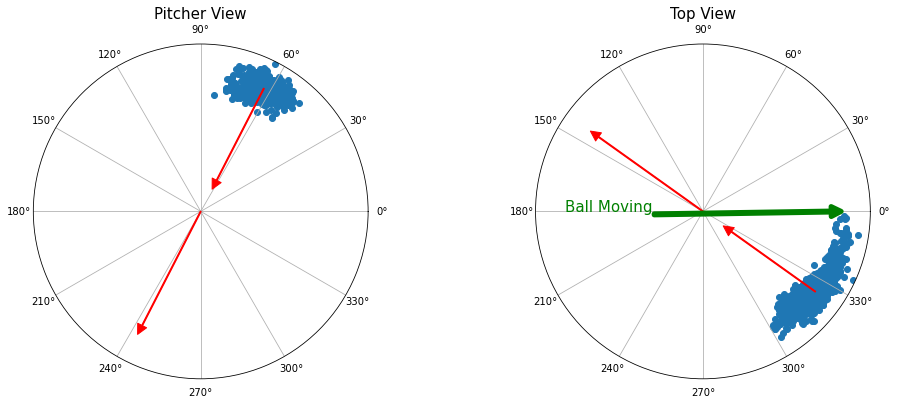

In [89]:
ball_spin(bauer,pitch_list[0])

포심의 회전을 시각화하였다.  
   
첫번째 그래프는 공을 투수의 시선으로 본 모습이다. 포심의 회전은 1시 방향에서 7시 방향으로의 회전이다. 이 회전으로 **상하 무브먼트가 크고, 좌우 무브먼트가 작은 것**을 알 수 있다. 1시 방향에서 화면 앞쪽으로 나와 7시 방향으로 회전하는 백스핀이기 때문에 무브먼트의 방향은 **상하 무브먼트는 위쪽, 좌우 무브먼트는 오른쪽**을 향한다.
   
두번째 그래프는 왼쪽(투수)에서 오른쪽(포수)으로 이동하는 공을 위쪽에서 본 모습이다. 이 회전을 통해 자이로 스핀의 정도를 확인할 수 있다. 공의 진행방향 축과 회전 축이 수직을 이룬다면, 공이 100% 자이로 스핀을 하는 것을 의미하게 되고 무브먼트가 0이 될 것이다. 위의 그래프를 통해 포심에는 조금의 자이로 스핀이 있다는 것을 확인할 수 있다.
   
위의 구종별 무브먼트를 시각화한 그래프(갈색)를 보면 일치하는 것을 확인할 수 있다.

----

<a id="curve"></a>
### 커브

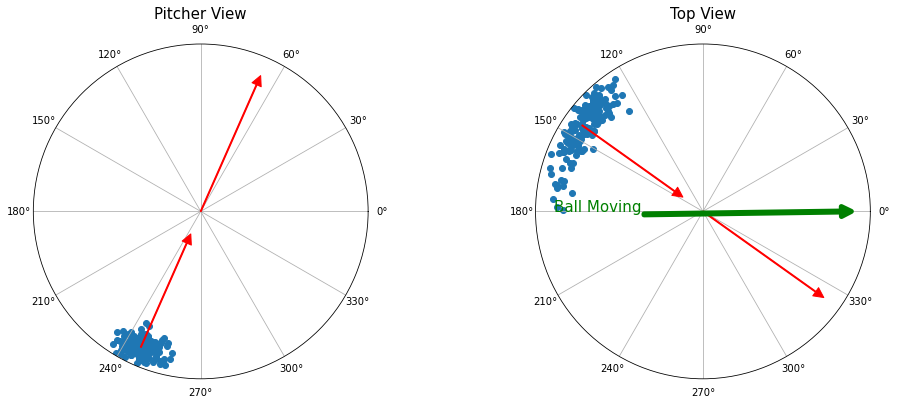

In [94]:
ball_spin(bauer, pitch_list[3])

커브의 회전을 시각화하였다.   
   
첫번째 그래프는 공을 투수의 시선으로 본 모습이다. 커브의 회전은 7시 방향에서 1시 방향으로의 회전이다. 이 회전으로 **상하 무브먼트가 크고, 좌우 무브먼트가 작은 것**을 알 수 있다. 7시 방향에서 화면 앞쪽으로 돌아 1시 방향으로 회전하는 탑스핀이기 때문에 무브먼트의 방향은 **상하 무브먼트는 아래쪽, 좌우 무브먼트는 왼쪽**을 향한다. 위의 포심과 정확히 반대되는 스핀을 가지고 있고, 무브먼트도 포심과 정확히 반대이다.
   
두번째 그래프는 왼쪽(투수)에서 오른쪽(포수)으로 이동하는 공을 위쪽에서 본 모습이다. 이 회전을 통해 자이로 스핀의 정도를 확인할 수 있다. 포심과 마찬가지로 적은 자이로 스핀이 있는 것을 확인할 수 있다.
   
 위의 구종별 무브먼트를 시각화한 그래프(초록색)를 보면 포심과 반대인 것을 확인할 수 있다.

----

<a id="slider"></a>
### 슬라이더

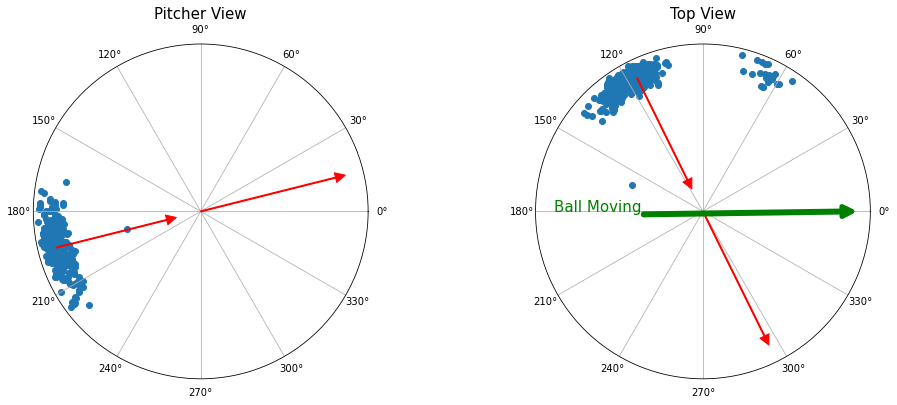

In [91]:
ball_spin(bauer, pitch_list[2])

슬라이더의 회전을 시각화하였다.   
   
첫번째 그래프는 공을 투수의 시선으로 본 모습이다. 슬라이더의 회전은 8시반 방향에서 2시반 방향으로의 회전이다. 이 회전으로 **상하 무브먼트가 작고, 좌우 무브먼트가 크다**는 것을 알 수 있다. 8시반 방향에서 화면 앞쪽으로 나와 2시반 방향으로 회전하는 스핀이기 때문에 무브먼트의 방향은 **상하 무브먼트는 아래쪽, 좌우 무브먼트는 왼쪽**을 향한다.
   
두번째 그래프는 왼쪽(투수)에서 오른쪽(포수)으로 이동하는 공을 위쪽에서 본 모습이다. 이 회전을 통해 자이로 스핀의 정도를 확인할 수 있다. 슬라이더의 경우, 포심이나 커브보다 회전각도가 공의 방향과 더욱 수직을 이루는 것을 확인할 수 있다. 이를 통해 **슬라이더의 자이로 스핀이 크다**는 것을 알 수 있다.
   
위의 구종별 무브먼트 그래프에서 파란색을 확인하면, 슬라이더가 왼쪽으로 무브먼트가 크고, 아래쪽으로 무브먼트가 작은 것을 확인할 수 있다. 또한, **자이로 스핀이 크기 때문에 전체적인 무브먼트가 작은 것**을 확인할 수 있다.

----

<a id="cutter"></a>
### 커터

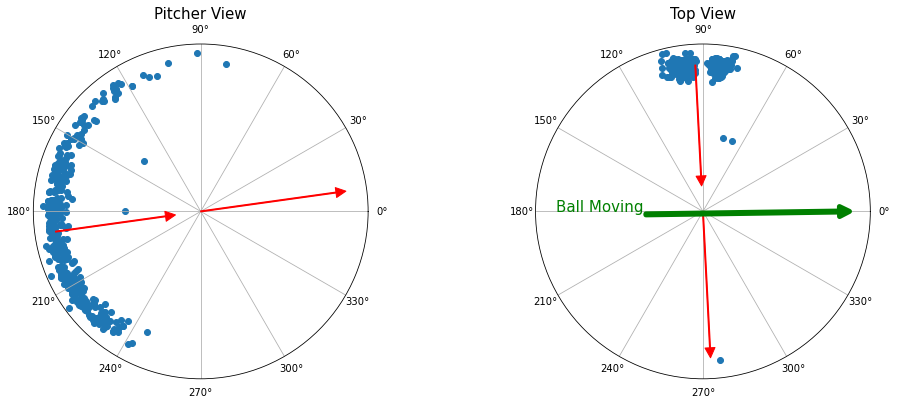

In [90]:
ball_spin(bauer, pitch_list[1])

커터의 회전을 시각화하였다.   
   
첫번째 그래프는 공을 투수의 시선으로 본 모습이다. 첫번째 그래프를 보면 다른 구종들과 달리 커터는 투구마다 회전 각도가 많이 변하는 것 같다. 그래도 회전이 대부분 9시에서 화면 앞쪽으로 나와 3시 방향으로 이루어지는 것을 보아 **상하무브먼트는 적고, 좌우무브먼트는 왼쪽**을 향하는 것을 알 수 있다. 
   
두번째 그래프는 왼쪽(투수)에서 오른쪽(포수)으로 이동하는 공을 위쪽에서 본 모습이다. 커터의 회전이 공의 진행 방향과 거의 수직을 이루는 것을 확인할 수 있다. 이를 통해 커터는 **자이로 스핀이 굉장히 크다**는 것을 확인할 수 있고, **무브먼트 또한 거의 없다**는 것을 알 수 있다.
   
구종별 무브먼트 그래프를 보면 회전에 의한 무브먼트와 일치하는 것을 확인할 수 있다. 커터에 해당하는 빨간점은 원점에 가장 가까워, 무브먼트가 거의 없고 좌우무브먼트가 왼쪽으로 조금 있다는 것을 확인할 수 있다.